In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchtext

from copy import deepcopy
from IPython.display import display
from collections import defaultdict
from torchvision import datasets
from torch.distributions import Categorical, Bernoulli 
from torch.utils.data import DataLoader
from IPython.display import clear_output

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
TODO: 

1. early stop
2. output node chosing by opt_cell
3. open Self_Attn (too slow)
4. Save Model
5. Model initialization
6. add error rate
7. one more zeros and ones cell
8. Retrieve cell dict
9. add feed forward process
10. change the num_attention 
'''
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.width',2000)

In [2]:
class args(object):
    
    ### Fetching ###
    
    model_type = 'Seq'
    
    batch_size = 5 
    
    if model_type == 'Seq':
        ### Seq
        
        layer_per_unit = 2
        layers = 10
        num_1x1Conv = 5
        num_gated = 5
        num_bns = 5
        num_act_fns = 4
        num_opts = layer_per_unit * layers + num_1x1Conv + num_gated + num_bns + num_act_fns
        fetching_dim = 512
        gated_dim = 512
        y_dim = 10
        num_putways = 3
        len_res = 1 # None

        TEXT = torchtext.data.Field(lower=True, include_lengths=True, batch_first=True)
        LABEL = torchtext.data.Field(sequential=False)
        train, test = torchtext.datasets.IMDB.splits(TEXT, LABEL, root = '../Data')

        TEXT.build_vocab(train)
        LABEL.build_vocab(train)

        train_iter, val_iter = torchtext.data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=-1)
        
        ntokens = len(TEXT.vocab)
        
    elif model_type == 'CNN':
        
        fetching_dim = 32
        num_putways = 4
        
        num_bns = 5
        num_attns = 2
        num_act_fns = 4
        num_weights = 5
        num_opts = num_weights*3 + num_bns + num_act_fns + num_attns
        
        
        img_name = 'cifar10'
    
        if img_name == 'mnist':
            img_channel = 1
            img_size = 28
            y_dim = 10
            img_path = '../Data/mnist'
            load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
            training_dataset = datasets.MNIST(img_path,train = True, transform = load_norm, download=False)
            test_dataset = datasets.MNIST(img_path,train = False, transform = load_norm, download=False)
        else:
            img_channel = 3
            img_size = 32
            y_dim = 10
            img_path = '../Data/cifar10'
            load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
            training_dataset = datasets.CIFAR10(img_path,train = True, transform=load_norm, download=True)
            test_dataset = datasets.CIFAR10(img_path,train = False, transform=load_norm, download=True)
    
    num_input_cells = 3
    num_iner_memories = 2
    num_cells = num_input_cells + num_iner_memories 
    num_time_steps = 5 
    num_fetching_steps = 5 
    
    ### ActorCritic ###
    
    emb_dim = 32
    LSTM_dim = 256
    
    ### Data ###
    
    ### Training ###
    
    eps = 1e-8
    discount = 0.9
    epoch = 150
    shared_lr = 0.0002
    controller_lr = 0.0002
    
    shared_maxsteps = 5 # 200
    controller_maxsteps = 5 # 200
    
    baseline_decay = 0.95
    val_test_steps = 5
    
    shared_grad_norm = None
    controller_grad_norm = None

    reward_c = 80
    
    critic_coef = 0.5
    entropy_coef = 0.05
    
    model_name = 'FetchingNAS' 
    model_path ='./'+ model_name +'/Model/'
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

if args.model_type == 'CNN':
    to_img= T.Compose([T.ToPILImage()])
    to_tensor = T.Compose([T.ToTensor()])
    load_norm = T.Compose([T.Resize((args.img_size,args.img_size)),
                           T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))])

In [3]:
class Flatten(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self,x):
        return (x.view(x.size(0),-1))

In [4]:
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    rewards = [0] * (values.size(0)-1) + [rewards]
    values = torch.cat([values,torch.tensor([[0.]]).to(device)],0)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1]  - values[step] # Remove the gamma in here?
        gae = delta + gamma * tau * gae # -value[step] will be used in the GAE step
        returns.insert(0, gae + values[step]) # put the new one at the first, cuz we are calculating the A_GAE inversely.
    return torch.stack(returns,0) # cuz we need the gradient of value, so we have to + value[step]

In [5]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        ActorCrtic For RNN
        '''
        
        self.retr_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.opt_emb = nn.Embedding(args.num_opts + 1, args.emb_dim)
        self.put_emb = nn.Embedding(args.num_putways, args.emb_dim)
        self.return_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.out_emb = nn.Embedding(2, args.emb_dim)
        
        self.lstm = nn.LSTMCell(args.emb_dim*args.num_fetching_steps, args.LSTM_dim)
        
        self.retr_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4, args.num_cells),
            nn.Softmax(-1),
        )
        
        self.opt_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4, args.num_opts + 1),
            nn.Softmax(-1),
        )
        
        # bns + weight + activation fns
        
        self.put_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4, args.num_putways),
            nn.Softmax(-1),
        )
        
        self.return_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4, args.num_cells),
            nn.Softmax(-1),
        )
        
        self.output_net = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.LeakyReLU(args.LSTM_dim//4),
            nn.Linear(args.LSTM_dim//4, 1),
            nn.Sigmoid(),
        )
        
        self.critic = nn.Sequential(
            nn.Linear(args.LSTM_dim, args.LSTM_dim//4),
            nn.ReLU(),
            nn.Linear(args.LSTM_dim //4, 1)
        )
        
        self.apply(self.weight_init)
        
    def forward(self, x, hidden = None ):
        
        '''
        # (Retrieve, opt(0~args.num_weight), BN(0~args.num_weight), Act_fn(0~args.num_act_fns), 
        Attn(0~args.num_Attn, Return, Put(0~args.num_putways-1))
        
        in short: [retr, opt, bn, act, attn, retur, put, output_signal]
        '''
    
        retr_e = self.retr_emb(x[:,0])
        opt_e = self.opt_emb(x[:,1])
        return_e = self.return_emb(x[:,2])
        put_e = self.put_emb(x[:,3])
        output_e = self.out_emb(x[:,4])
        
        lstm_input = torch.cat([retr_e, opt_e, return_e, put_e, output_e],1)
        
        h, c = self.lstm(lstm_input, hidden)
       
        retr_dist = Categorical(self.retr_net(h))
        opt_dist = Categorical(self.opt_net(h))
        return_dist = Categorical(self.return_net(h))
        put_dist = Categorical(self.put_net(h))
        output_dist = Bernoulli(self.output_net(h))
        
        dists = (retr_dist, opt_dist, return_dist, put_dist, output_dist)
        
        value = self.critic(h)
        
        return dists , (h,c), value
    
    def weight_init(self,m):
        
        if type(m) in [nn.Linear]:
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0.1)
            
    def sample(self, x, hidden = None, with_detials = False):
        
        dists, hidden, value = self.forward(x, hidden)
        
        retr_dist, opt_dist, return_dist, put_dist, output_dist = dists 
        
        retr = retr_dist.sample()
        opt = opt_dist.sample()
        retur = return_dist.sample()
        put = put_dist.sample()
        output_s = output_dist.sample().squeeze(-1)

        samples = torch.stack([retr, opt, retur, put, output_s.long()],1)
        
        if with_detials:

            entropy = torch.stack([retr_dist.entropy(), opt_dist.entropy(), 
                                   return_dist.entropy(), put_dist.entropy(),
                                    output_dist.entropy().squeeze(-1)],-1)

            retr_logprob = retr_dist.log_prob(retr)
            opt_logprob = opt_dist.log_prob(opt)
            return_logprob = return_dist.log_prob(retur)
            put_log_prob = put_dist.log_prob(put)
            output_log_prob = output_dist.log_prob(output_s).squeeze(-1)
            
            log_probs = torch.stack([retr_logprob, opt_logprob, return_logprob, put_log_prob, output_log_prob],1)
            
            return samples, hidden, entropy, log_probs, value
        
        return samples, hidden
    
    def generate_dags(self, samples):
        
        # [retr, opt, attn, retur, put]
        
        dags = []
        
        for sample in samples:
            
            dag_dict = {}
            
            dag_dict['Retrieve_cell'] = sample[0].item()
            
            if sample[1] == 0:
                dag_dict['Operation'] = None
            else:
                dag_dict['Operation'] = sample[1].item() - 1
            
            dag_dict['Return_cell'] = sample[2].item()

            dag_dict['Put'] = sample[3].item()
            
            dag_dict['Output'] = sample[4].item()
            
            dags.append(dag_dict)
            
        return dags
    
    def straight_dags(self, x = None, hidden = None, num_steps = 5 , batch_size = 1, with_details = False):
        
        if x is None:
            x = torch.zeros(batch_size,args.num_fetching_steps).to(device).long()
        
        sample_list = []
        entropies = []
        log_probs = []
        values = []
        
        for _ in range(args.num_time_steps): 
            
            if with_details:
                
                x, hidden, entropy, log_prob, value = self.sample(x, hidden, with_detials = True)
                entropies.append(entropy)
                log_probs.append(log_prob)
                values.append(value)
                
            else:
                
                x, hidden = self.sample(x, hidden)    
                
            sample_list.append(x)
            
        samples = torch.stack(sample_list,1)
        
        dags_dict_list = []
        
        for dag in samples:
            # batch_order 
            dags_dict_list.append(self.generate_dags(dag))
            
        if with_details: 
            return dags_dict_list, torch.stack(entropies,1).sum(-1).squeeze().unsqueeze(-1), torch.stack(log_probs,1).squeeze(),torch.stack(values,1).squeeze().unsqueeze(-1)
    
        return dags_dict_list
        

In [6]:
class GatedLinearUnit(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.st_conv = nn.Conv1d(args.fetching_dim, args.gated_dim,1,1,0)
        
        self.end_conv = nn.Conv1d(args.gated_dim // 2, args.fetching_dim,1,1,0)
        
    def forward(self, x):
        x = self.st_conv(x)
        a, b = x.split(x.size(1)//2, dim=1)
        x = torch.tanh(a) * torch.sigmoid(b)
        x = self.end_conv(x)
        return x
    
class DilationConv1d(nn.Conv1d):
    def __init__(self, kernel_size = 3, dilation = 1):
        padding = (kernel_size - 1) // 2 * dilation
        super().__init__(args.fetching_dim, args.fetching_dim, kernel_size,
                         padding = padding, dilation = dilation)
        
    def forward(self,x):
        return super().forward(x)
        
        

class SeqCell(nn.Module):
    def __init__(self, num_conv1d = 5, num_bn = 5, num_cells = 5):
        super().__init__()
        
        self.num_cells = num_cells
        self.opts = nn.ModuleList()
        
        for _ in range(args.layer_per_unit):
            for layer in range(args.layers):
                dilation = 2**layer
                conv = DilationConv1d(dilation = dilation)
                self.opts.append(conv)
        
        self.opts.extend([GatedLinearUnit() for _ in range(args.num_gated)])
        
        # Normal Conv1d
        
        # self.convs.extend([DilationConv1d(kernel_size = 3, dilation = 1) for _ in range(args.num_1x1Conv)])
        
        # Conv1x1
        
        self.opts.extend([DilationConv1d(kernel_size = 1, dilation = 1) for _ in range(args.num_1x1Conv)])
        
        self.iner_memories = nn.ParameterList()
        self.iner_memories.extend([nn.Parameter(torch.randn(1,args.fetching_dim, 1)) for _ in range(args.num_iner_memories)])
        
        self.opts.extend([nn.Sigmoid(),
                               nn.ReLU(inplace=True),
                               nn.LeakyReLU(0.2,inplace=True),
                               nn.Tanh(),
                              ])
    
        self.opts.append(nn.BatchNorm1d(args.fetching_dim, affine = False))
        self.opts.extend([nn.BatchNorm1d(args.fetching_dim) for _ in range(args.num_bns-1)])
        
        
    def forward(self, x, dags):
        
        B,C,L = x.size()
        
        cells = [x] * (args.num_input_cells) + [m.repeat(B,1,L) for m in [*self.iner_memories]]
        
        outputs = []

        for dag in dags:
            
            opting_cell = cells[dag['Retrieve_cell']].clone()
            
            if not dag['Operation'] is None:
                opting_cell = self.opts[dag['Operation']](opting_cell)
            if dag['Put'] == 0 :
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2:
                cells[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError
            if dag['Output']:
                outputs.append(torch.mean(cells[dag['Return_cell']],-1)) # reduce the L
                # return torch.mean(cells[dag['Return_cell']],-1)
            if not args.len_res is None and len(outputs) == args.len_res:
                return torch.stack(outputs,0)
        
        if not args.len_res is None:
            return torch.mean(torch.stack(cells[:-args.num_iner_memories],0),0).mean(-1)
        
        return torch.stack(outputs,0) if len(outputs) != 0 else torch.stack(cells[:-args.num_iner_memories],0)
    
    
    def dags_translate(self, dags_):
        dags = deepcopy(dags_)
        for dag in dags:
            dag['Operation_name'] = str(self.opts[dag['Operation']])
            if dag['Put'] == 0:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 1:
                dag['Put'] = 'Emlement_Wise*'
            elif dag['Put'] == 2:
                dag['Put'] = 'Inplace'
            dag['Output'] = bool(dag['Output'])
        return dags

In [7]:
class SeqContainer(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.emb = nn.Embedding(args.ntokens, args.fetching_dim)
        
        self.cell = SeqCell()
        
        self.end = nn.Linear(args.fetching_dim, 3)
        
        self.Loss = nn.CrossEntropyLoss()
        
    def forward(self, x, dags):
        
        if x.dim() == 1:
            x = x.unsqueeze(-1, x)

        input_ = self.emb(x).permute(0,2,1)
        
        output = self.cell(input_, dags)
        
        output = self.end(output)
        
        return output
        
    def get_loss(self, loader, dags):
        
        batch = next(iter(loader))
        text = batch.text[0].to(device)
        targets = batch.label.to(device)
        out = self.forward(text, dags[0]).squeeze(0)
        
        loss = self.Loss(out, targets)
        
        return loss
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
            

In [8]:
# A = ActorCritic()
# dag = A.straight_dags()
# S = SeqContainer()
# k = S(torch.ones(10,20).long(),dag[0])

In [9]:
class Flatten(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self,x):
        return (x.view(x.size(0),-1))

class Self_Attn(nn.Module):
    def __init__(self, dim):
        super(Self_Attn, self).__init__()
        
        self.dim = dim
        
        self.query_conv = nn.Conv2d(dim, dim//8, 1)
        self.key_conv = nn.Conv2d(dim, dim//8, 1)
        self.value_conv = nn.Conv2d(dim, dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.sm = nn.Softmax(dim= -1)
    
    def forward(self, x):
        
        batch_size, C, width, height = x.size()
        N = width * height
        query_out = self.query_conv(x).view(batch_size, -1, N).permute(0, 2, 1) 
        key_out = self.key_conv(x).view(batch_size, -1, N) 
        attn = self.sm(torch.bmm(query_out, key_out)) 
        value_out = self.value_conv(x).view(batch_size, -1, N) 
        out = torch.bmm(value_out, attn.permute(0,2,1)).view(batch_size, C, width, height)
        out = self.gamma * out + x
        
        return out

In [10]:
class CNNCell(nn.Module):
    def __init__(self):
        super().__init__()
        
        '''
        The dim has to be more than 8
        '''
        
        self.opts = nn.ModuleList()
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 3, 1, 1) for _ in range(args.num_weights)])
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 1, 1, 0) for _ in range(args.num_weights)])
        self.opts.extend([nn.Conv2d(args.fetching_dim, args.fetching_dim, 5, 1, 2) for _ in range(args.num_weights)])
        if args.num_bns > 0:
            self.opts.append(nn.BatchNorm2d(args.fetching_dim, affine= False))
            self.opts.extend([nn.BatchNorm2d(args.fetching_dim) for _ in range(args.num_bns-1)])
        

        self.opts.extend([Self_Attn(args.fetching_dim) for _ in range(args.num_attns)])
        
        
        self.opts.extend([nn.Sigmoid(),
                       nn.ReLU(inplace=True),
                       nn.LeakyReLU(0.2,inplace=True),
                       nn.Tanh(),
                      ])
        
        self.iner_memories = nn.ParameterList()
        self.iner_memories.extend([nn.Parameter(torch.randn(1,args.fetching_dim, args.img_size, args.img_size)) for _ in range(args.num_iner_memories)])
        
    def forward(self, x, dags):
        
        # cells = [x]*self.num_cells
        
        B,C,W,H = x.size()
        
        cells = [x] * (args.num_input_cells) + [m.repeat(B,1,1,1) for m in [*self.iner_memories]] 
        
        # N = W*H
        
        for dag in dags:
            opting_cell = cells[dag['Retrieve_cell']].clone()
            if not dag['Operation'] is None:
                opting_cell = self.opts[dag['Operation']](opting_cell)
            if dag['Put'] == 0 :
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2 :
                cells[dag['Return_cell']] = torch.bmm(opting_cell.view(-1,W,H),cells[dag['Return_cell']].view(-1,W,H).permute(0,2,1)).view(B,C,W,H)
            elif dag['Put'] == 3:
                cells[dag['Return_cell']] = opting_cell
            else: 
                raise NotImplementedError
            if dag['Output']:
                return cells[dag['Return_cell']] 

        return torch.mean(torch.stack(cells[:-args.num_iner_memories],0),0) # don't return the iner memories.
    
    def dags_translate(self, dags_):
        dags = deepcopy(dags_)
        '''
        add one more col for operation name
        '''
        for dag in dags:
            dag['Operation_name'] = str(self.opts[dag['Operation']])
            if dag['Put'] == 0:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 1:
                dag['Put'] = 'Emlement_Wise*'
            elif dag['Put'] == 2:
                dag['Put'] = 'Bmm'
            elif dag['Put'] == 3:
                dag['Put'] = 'Inplace'
            dag['Output'] = bool(dag['Output'])
        return dags

In [11]:
class CNNContainer(nn.Module):
    
    def __init__(self,):
        
        '''
        For MNIST
        '''
        
        super().__init__()
        
        self.cell = CNNCell()
        
        self.cnn_st = nn.Sequential(
            nn.Conv2d(args.img_channel, args.fetching_dim, 1, 1, 0),
        )
        
        self.cnn_end = nn.Sequential(
            nn.Conv2d(args.fetching_dim, 1, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            Flatten(),
            nn.Linear(args.img_size*args.img_size, args.y_dim),
        )
        
        self.Loss = nn.CrossEntropyLoss()
        
    def forward(self, x, dags):
        
        input_ = self.cnn_st(x)
        
        output = self.cell(input_, dags)
        
        output = self.cnn_end(output)
        
        return output
        
    def get_loss(self, loader, dags):
        
        imgs, targets = iter(loader).next()
        
        imgs = imgs.to(device)
        
        targets = targets.to(device)
            
        out = self.forward(imgs, dags[0])
            
        loss = self.Loss(out, targets)
        
        return loss
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
        

In [12]:
# A = ActorCritic()
# dag = A.straight_dags()
# C = CNNContainer()
# C(torch.randn(5,args.img_channel,args.img_size,args.img_size), dag[0]).shape

In [13]:
class FetchingNAS(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        
        if args.model_type == "CNN":
            self.shared = CNNContainer()
            self.training_loader = DataLoader(args.training_dataset,
                            batch_size= args.batch_size,
                            shuffle=True)
        
            self.valid_loader = DataLoader(args.test_dataset,
                                        batch_size= args.batch_size,
                                        shuffle=True)
        elif args.model_type == "Seq":
            self.shared = SeqContainer()
            self.training_loader = args.train_iter
            self.valid_loader = args.val_iter
            
        else:
            raise NotImplementedError
            
        self.controller = ActorCritic()
        
        self.shared_optim = optim.Adam(self.shared.parameters(), lr = args.shared_lr)
        self.controller_optim = optim.SGD(self.controller.parameters(), lr = args.controller_lr)
        
        self.CE = nn.CrossEntropyLoss()
        self.max_R = None
        self.best_dag = None
        self.controller_hist = defaultdict(list)
        
        self.apply(self.weight_init)
        
    def train_shared(self,):
        
        self.shared.train()
        self.controller.eval()
        
        step = 0
        
        while step < args.shared_maxsteps:
            
            self.shared_optim.zero_grad()
            
            dags = self.controller.straight_dags(num_steps = args.num_time_steps)
            
            loss = self.shared.get_loss(self.training_loader, dags)
            
            loss.backward()
            if not args.shared_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.shared.parameters(), args.shared_grad_norm)
            
            self.shared_optim.step()
            
            step += 1 
    
    def get_reward(self, dags, entropies,):
        
        loss = 0
        
        for i in range(args.val_test_steps):
            
            loss += self.shared.get_loss(self.valid_loader, dags)
            
        loss /= args.val_test_steps
        
        loss_ppl = loss.exp()
        
        R = (args.reward_c / ((loss_ppl ** 2) + args.eps)) # * torch.ones_like(entropies)
        
        return R
        
        # If we sample a dag a time, then change the structure of sampling dag    
            
    def train_controller(self,):
        
        self.controller.train()
        
        step = 0
        
#         baseline = None

        self.en_losses = []
    
        self.controller_losses = []
        
        self.actor_losses = []
        
        self.critic_losses = []
        
        while step < args.controller_maxsteps:
            
            self.controller_optim.zero_grad()
            
            dags, entropy, log_prob, value = self.controller.straight_dags(num_steps = args.num_time_steps ,with_details = True)
        
            with torch.no_grad():
                
                R = self.get_reward(dags, entropy)
                
            if self.max_R is None:
                self.max_R = R.max()
                self.best_dag = dags[0]
            else:
                if R.max() > self.max_R:
                    self.max_R = R.max()
                    self.best_dag = dags[0]
             
            self.controller_hist['Rewards'].append(R.item())
            
            returns = compute_gae(R, value)
            
            adv = returns.detach() - value 
            
            actor_loss = (- log_prob * adv).mean()
            
            critic_loss = args.critic_coef * adv.pow(2).mean() 
            
            en_loss = args.entropy_coef * entropy.mean()
            
            loss = actor_loss + critic_loss - en_loss
            
            self.actor_losses.append(actor_loss.item())
            self.critic_losses.append(critic_loss.item())
            self.en_losses.append(-en_loss.item())
            self.controller_losses.append(loss.item())
            
            loss.backward()
            
            if not args.controller_grad_norm is None:
                nn.utils.clip_grad_norm_(self.controller.parameters(), args.controller_grad_norm)
            
            self.controller_optim.step()
            
            step += 1
        
    
    def train(self, n_epoch, save_freq = 30):
        
        start_t = time.time()

        for self.epoch in range(n_epoch):
            
            self.train_shared()
            
            # Trian the shared model's parameter for shared_maxsteps

            self.train_controller()
            
            self.plot_controller_hist('_Rewards')
            
            end_t = time.time()

            display(self.dags_df(self.shared.cell.dags_translate(self.best_dag)))
            
            print('Epoch : [%d] Lasting Time: [%.4f]'% (self.epoch, end_t - start_t))
            print('Loss | Controller [%.4f] | Actor [%.4f] | Critic [%.4f] | Entropy [%.4f]' %\
                   (sum(self.controller_losses)/ len(self.controller_losses),
                   (sum(self.actor_losses)/len(self.actor_losses)),
                   (sum(self.critic_losses)/len(self.critic_losses)),
                   (sum(self.en_losses)/len(self.en_losses))
                  ))
            
            if self.epoch % save_freq == 0 and self.epoch != 0:
                self.model_save('Training')
            # Train controller for controler_maxsteps
            
    def plot_controller_hist(self, step):
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in self.controller_hist.keys():
            plt.plot(self.controller_hist[name], label = name)
            plt.xlabel('Number of Steps',fontsize=15)
            plt.ylabel( name, fontsize=15)
            plt.title(name, fontsize=30, fontweight ="bold")
            plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png")
    
    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
    
    def model_save(self, step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
    def dags_df(self, dags, delete = True):
        
        df = pd.DataFrame(dags)[['Retrieve_cell','Operation','Operation_name','Return_cell','Put','Output']]
        
        idx_list = df.index[df['Output']].tolist()
        
        if len(idx_list) == 0:
            return df
        else:
            idx = idx_list[0]
        
        return df.loc[:idx] if delete else df
    
    def weight_init(self,m):
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
        
 

In [14]:
F = FetchingNAS()

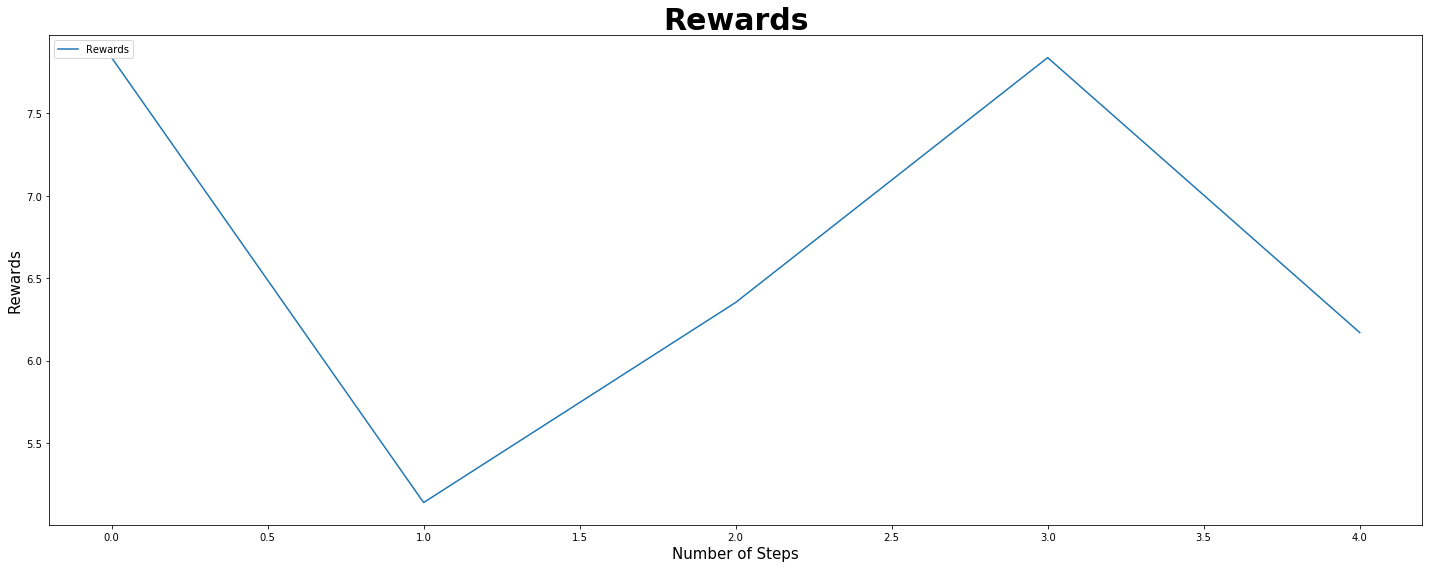

,Retrieve_cell,Operation,Operation_name,Return_cell,Put,Output
0,2,36,"BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",3,Inplace,True


Epoch : [0] Lasting Time: [7.3964]
Loss | Controller [15.6834] | Actor [1.6532] | Critic [14.1273] | Entropy [-0.0972]


In [15]:
F.train(1)